# 명함인식 OCR 개요
### 1. 실습 대상 명함 소개
### 2. OCR을 위한 원본 이미지 전처리
* 2.1 방법1 : 좌표의 이미지를 직접 추출해서 이미지 정렬(권장X)
* 2.1 방법2 : contour함수를 통해 꼭지점을 찾아 기울어진 명함을 일치시켜 명함 추출

In [1]:
import scipy.stats as sp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from PIL import ImageFont, ImageDraw, Image
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,6)

In [2]:
def imshow(tit, image):
    plt.title(tit)
    if len(image.shape) == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(image, cmap='gray')
    plt.show()

## 1. 실습 대상 명함 소개

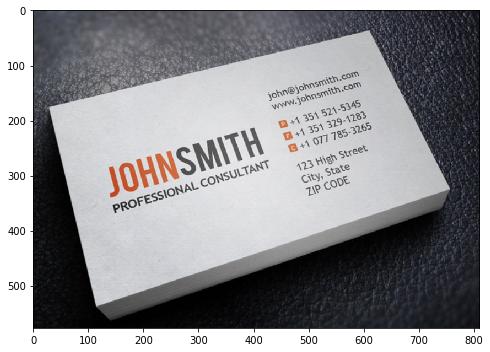

In [3]:
img = cv2.imread("./datas/namecard.PNG")
imshow("", img)

#### 명함이 기울어져 있기에 테서렉트를 통한 문자 추출에 실패함을 확인할 수 있다.

In [4]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

original = pytesseract.image_to_string("./datas/namecard.PNG")
print(original)

## 2. OCR을 위한 원본 이미지 전처리
* 기울어진 명함을 일직선으로 배치

### 2.1 방법1 : 좌표의 이미지를 직접 추출해서 이미지 정렬(권장X)
* 한개의 대상만 가능하며, 변형된 이미지에는 수행 불가하기 때문

In [5]:
img = cv2.imread("./datas/namecard.PNG")

height, width = img.shape[:2]

point_list = [[27, 179], [611, 36], [118, 534], [754, 325]]

pts1 = np.float32([list(point_list[0]),
                 list(point_list[1]),
                 list(point_list[2]),
                 list(point_list[3])])
print(pts1)

# 실제 명함만의 거리를 구하려면 점들간의 피타고라스를 통해 길이 측정해라
#height = sqrt((611-27)**2 + (36-179)**2)
# weight = 

[[ 27. 179.]
 [611.  36.]
 [118. 534.]
 [754. 325.]]


In [6]:
pts2 = np.float32([[0,0], [width/2,0], [0,height/2], [width/2, height/2]]) 
#pts2 = np.float32([[0,0], [width,0], [0,height], [width, height]]) 
print(pts2)

[[  0.    0. ]
 [405.5   0. ]
 [  0.  288.5]
 [405.5 288.5]]


In [7]:
M = cv2.getPerspectiveTransform(pts1, pts2)
print(M)

[[ 6.11584185e-01 -1.56772284e-01  1.15494658e+01]
 [ 2.26751420e-01  9.26033771e-01 -1.71882333e+02]
 [-1.29571760e-04  4.23781663e-04  1.00000000e+00]]


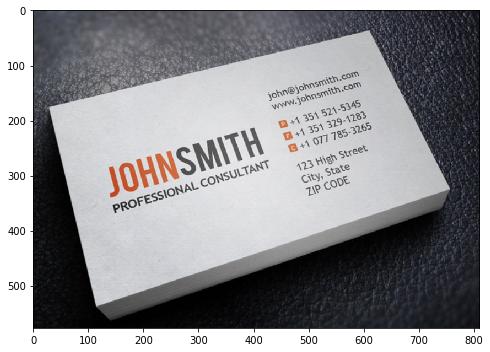

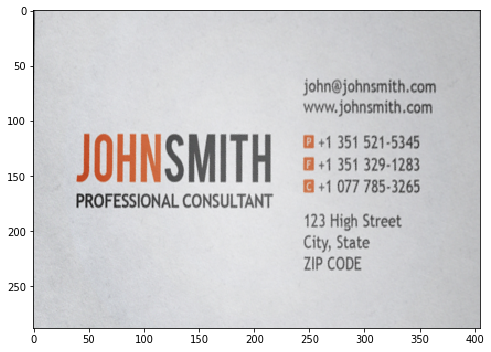

In [8]:
img_result = cv2.warpPerspective(img, M, (width, height))
img_result = cv2.warpPerspective(img, M, (int(width/2), int(height/2)))
imshow("", img)
imshow("", img_result)

In [9]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

preprocessing_ocr = pytesseract.image_to_string(img_result)
print(preprocessing_ocr)

JOHNSMITH

PROFESSIONAL CONSULTANT

 

john@johnsmith.com
wow. johnsmith.com

+1 351 521-5345
+1 351 329-1283
+1 077 785-3265

123 High Street
City, State
11P CODE


### 2.1 방법2 : contour함수를 통해 꼭지점을 찾아 기울어진 명함을 일치시켜 명함 추출

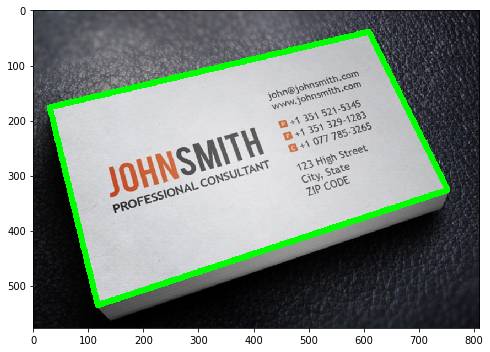

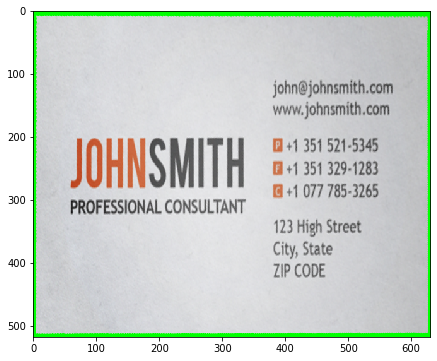

JOWNSMITH

PROFESSIONAL CONSULTANT

john@johnsmith.com
www. johnsmith.com

+4 351 521-5345
Gi +1 351 329-1283
+1 077 785-3265

123 High Street
City, State
ZIP CODE


In [10]:
import math

# 이미지 읽기
img = cv2.imread("./datas/namecard.PNG")
# 이미지 Gray 변환
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 이미지 내 노이즈 제거
img_blur = cv2.GaussianBlur(gray, (19, 19), 0)
# 이진화 작업을 통한 이미지 선명화
_, binary = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02*peri, True)
    
    # 사각형인 물체만 추출
    if len(approx) == 4:
            
        ## 원본 이미지(img)에 사각형인 물체를 그림 
        cv2.drawContours(img, [approx], -1, (0, 255, 0), 10)

        # 원본 이미지의 가로 및 세로의 길이
        # height, width = img.shape[:2]
        # print(height, width)
        
        # (전처리 전) 원본 명함의 꼭지점 위치
        pts1 = np.float32([approx[1][0][:], approx[0][0][:], approx[2][0][:], approx[3][0][:]])
        #print(pts1)
        
        # (전처리 작업) 원본 명함의 가로와 세로의 길이 구함
        width = (math.sqrt((approx[1][0][0]-approx[0][0][0])**2 + (approx[1][0][1]-approx[0][0][1])**2)
                + math.sqrt((approx[2][0][0]-approx[3][0][0])**2 + (approx[2][0][1]-approx[3][0][1])**2))/2
        height = (math.sqrt((approx[1][0][0]-approx[2][0][0])**2 + (approx[1][0][1]-approx[2][0][1])**2)
                + math.sqrt((approx[2][0][0]-approx[3][0][0])**2 + (approx[2][0][1]-approx[3][0][1])**2))/2
        # (전처리 작업) 추출한 가로와 세로를 바탕으로 사각형의 좌표를 만듬
        pts2 = np.float32([[0,0], [width, 0], [0,height], [width, height]]) 

        # 전처리한 결과를 새로운 이미지(img_result)에 적용
        M = cv2.getPerspectiveTransform(pts1, pts2)
        # print(M)
        img_result = cv2.warpPerspective(img, M, (int(width), int(height)))
        
imshow("", img)
imshow("", img_result)

cv2.imwrite("out.png", img_result)

# 테서렉트를 통한 문자 추출
str = pytesseract.image_to_string(img_result)
print(str)